**This scanpy  single cell RNA tutorial is recently updated to handle issues such as issues in neighbours, umap etc** 

In [2]:
import pandas as pd
import scanpy as sc

**Read matrix data from the folder**

In [3]:
adata = sc.read_10x_mtx(
    "data/filtered_gene_bc_matrices/hg19/",  # the directory with the `.mtx` file
    var_names="gene_symbols",  # use gene symbols for the variable names 
    cache=True,              # for faster subsequent reading
)

In [4]:
adata.var_names_make_unique()  # this is unnecessary if using `var_names='gene_ids'` in `sc.read_10x_mtx`

In [5]:
adata

AnnData object with n_obs × n_vars = 2700 × 32738
    var: 'gene_ids'

In [6]:
results_file = "write/pbmc3k.h5ad"

**Preprocessing**

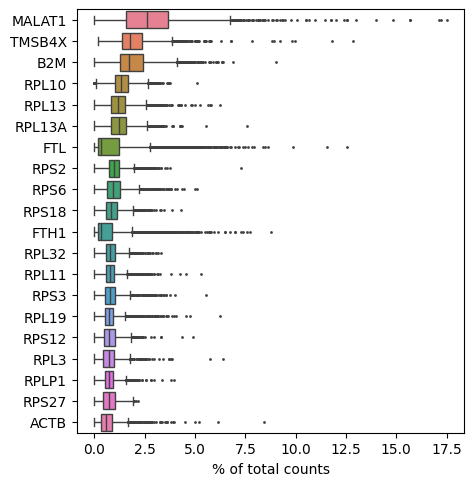

In [7]:
sc.pl.highest_expr_genes(adata, n_top=20)

**Filtering step**

In [8]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

**Annotate the group of mitochondrial genes as "mt"**

In [9]:

adata.var["mt"] = adata.var_names.str.startswith("MT-")
sc.pp.calculate_qc_metrics(
    adata, qc_vars=["mt"], percent_top=None, log1p=False, inplace=True
)

/Users/sasi/opt/anaconda3/lib/python3.9/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


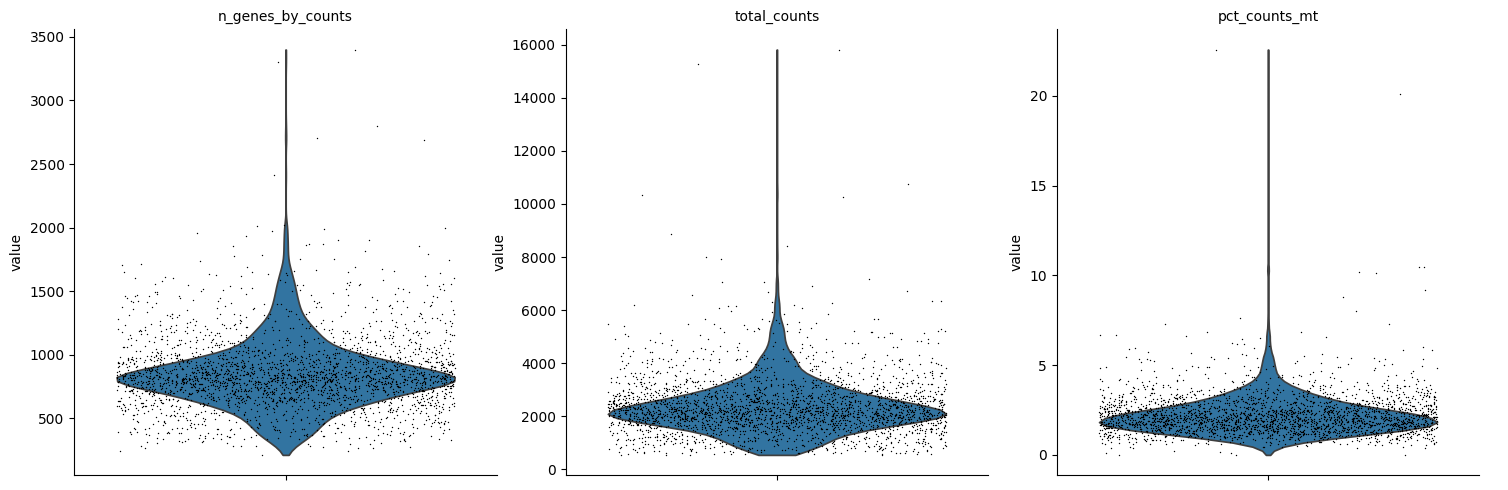

In [10]:
sc.pl.violin(
    adata,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    jitter=0.4,
    multi_panel=True,
)

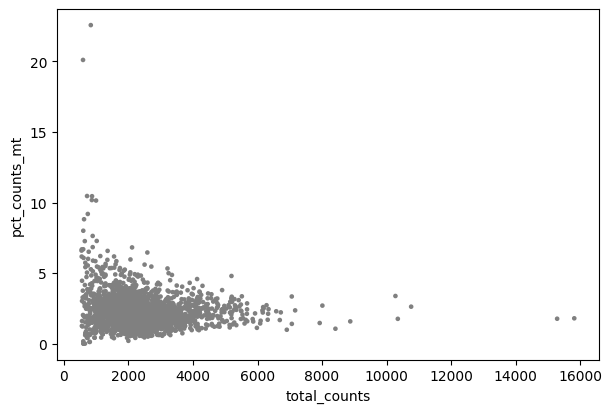

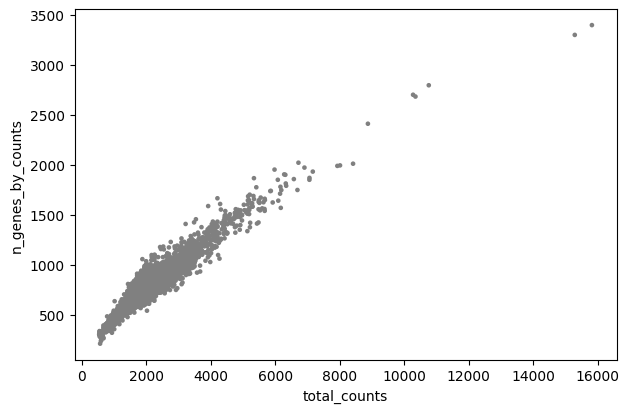

In [11]:
sc.pl.scatter(adata, x="total_counts", y="pct_counts_mt")
sc.pl.scatter(adata, x="total_counts", y="n_genes_by_counts")

**Remove cells that have too many mitochondrial genes expressed or too many total counts**

In [12]:
adata = adata[adata.obs.n_genes_by_counts < 2500, :]
adata = adata[adata.obs.pct_counts_mt < 5, :].copy()

**Total-count normalize (library-size correct) the data matrix 
 to 10,000 reads per cell, so that counts become comparable among cells**

In [13]:
sc.pp.normalize_total(adata, target_sum=1e4)

In [14]:
sc.pp.log1p(adata)

In [15]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

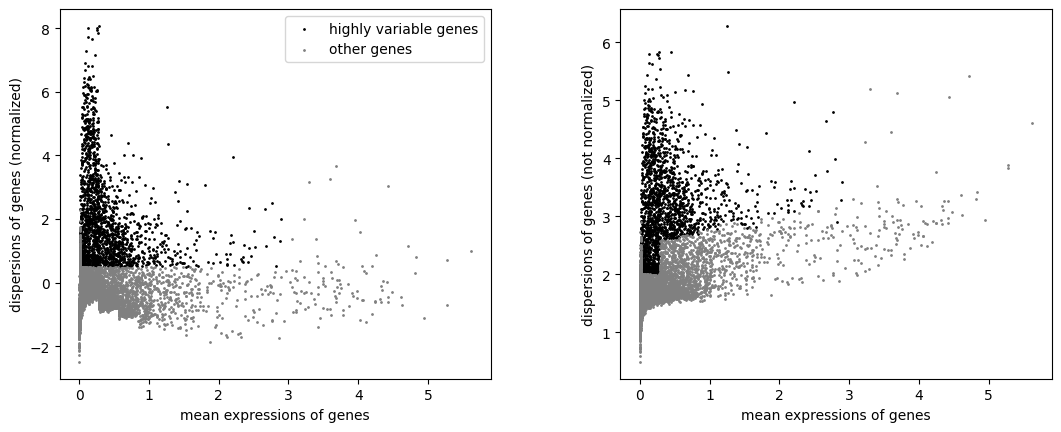

In [16]:
sc.pl.highly_variable_genes(adata)

In [17]:
adata.raw = adata

**Filter high Variable gene,Regress out effects of total counts per cell and the percentage of mitochondrial genes expressed. Scale the data to unit variance** 

In [18]:
adata = adata[:, adata.var.highly_variable]

In [19]:
sc.pp.regress_out(adata, ["total_counts", "pct_counts_mt"])

/Users/sasi/opt/anaconda3/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:644: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [20]:
sc.pp.scale(adata, max_value=10)

**Principal component analysis**

In [21]:
sc.tl.pca(adata, svd_solver="arpack")

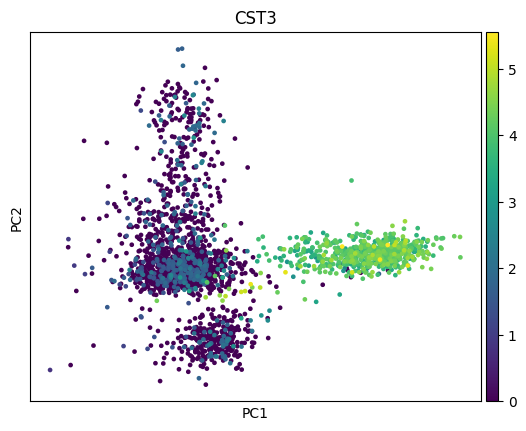

In [22]:
sc.pl.pca(adata, color="CST3")

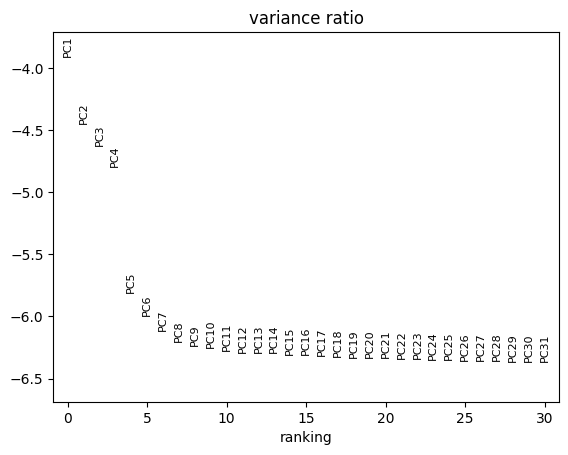

In [23]:
sc.pl.pca_variance_ratio(adata, log=True)

In [24]:
adata.write(results_file)

In [25]:
adata

AnnData object with n_obs × n_vars = 2638 × 1838
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

**Install below to avoid attribute error**

In [26]:
#!pip install daal==2021.4.0

In [27]:
#!pip install threadpoolctl==3.1.0
#!pip install numba==0.56.0 
       #or
#conda install -c numba numba==0.56.2

**Computing the neighborhood graph**

In [28]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)
#sc.pp.neighbors(adata)

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [29]:
#pip install leidenalg

In [30]:
sc.tl.leiden(adata)

/var/folders/y8/f_r4xq2d0pl9ffwb4b9z6bfw0000gn/T/ipykernel_5625/3467744858.py:1: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata)


In [31]:
sc.tl.paga(adata)
sc.pl.paga(adata, plot=False)  # remove `plot=False` if you want to see the coarse-grained graph
sc.tl.umap(adata, init_pos='paga')

In [32]:
#sc.tl.umap(adata)  ## this step might take long time, so you could do the below step .

**Clustering the neighborhood graph**

In [33]:
sc.tl.leiden(
    adata,
    resolution=0.9,
    random_state=0,
    flavor="igraph",
    n_iterations=2,
    directed=False,
)

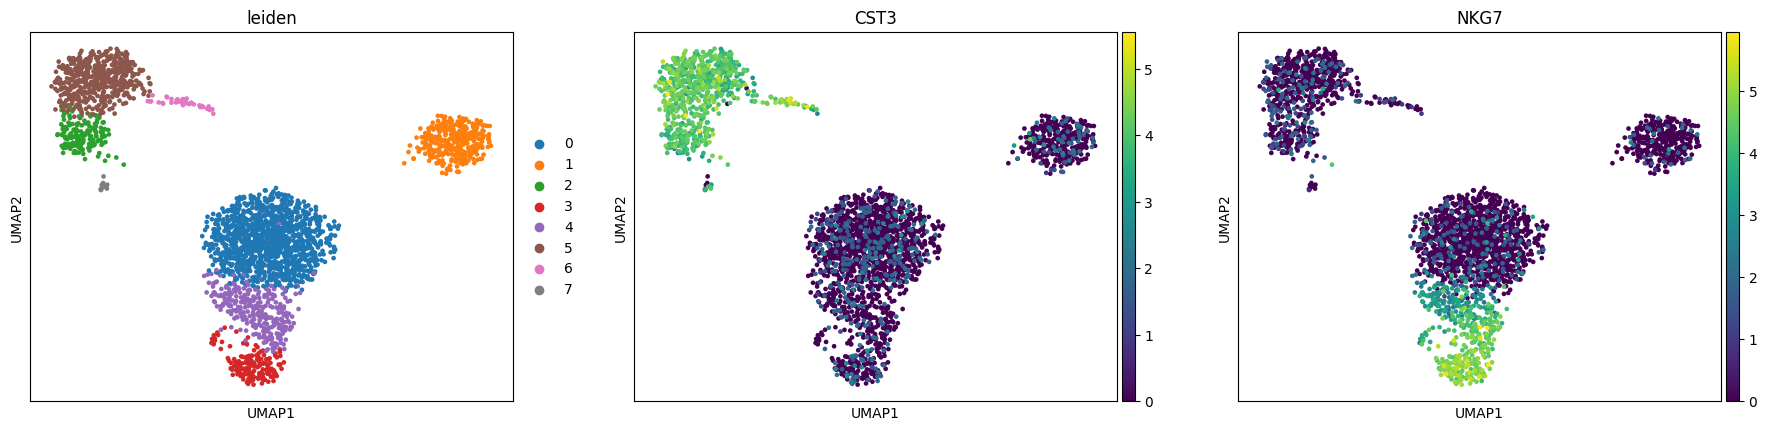

In [34]:
sc.pl.umap(adata, color=["leiden", "CST3", "NKG7"])

In [35]:
adata.write(results_file)

**Finding marker genes**

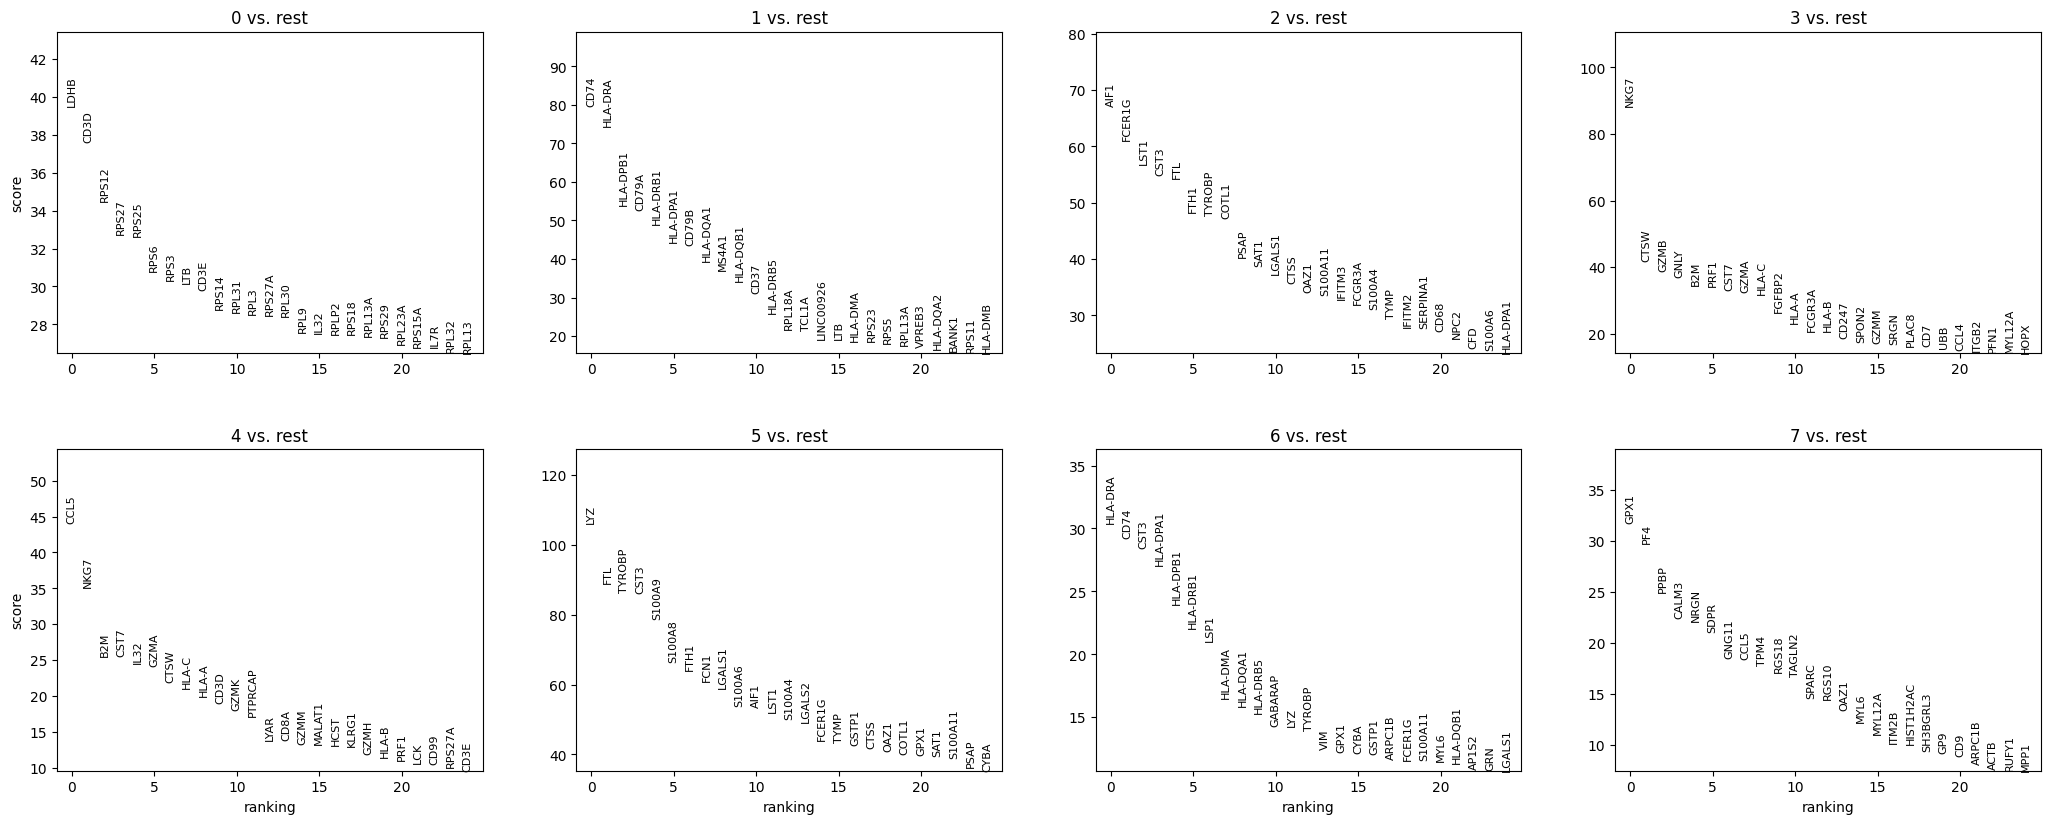

In [36]:
sc.tl.rank_genes_groups(adata, "leiden", method="t-test")
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

In [37]:
sc.settings.verbosity = 2  # reduce the verbosity

ranking genes
    finished (0:00:02)


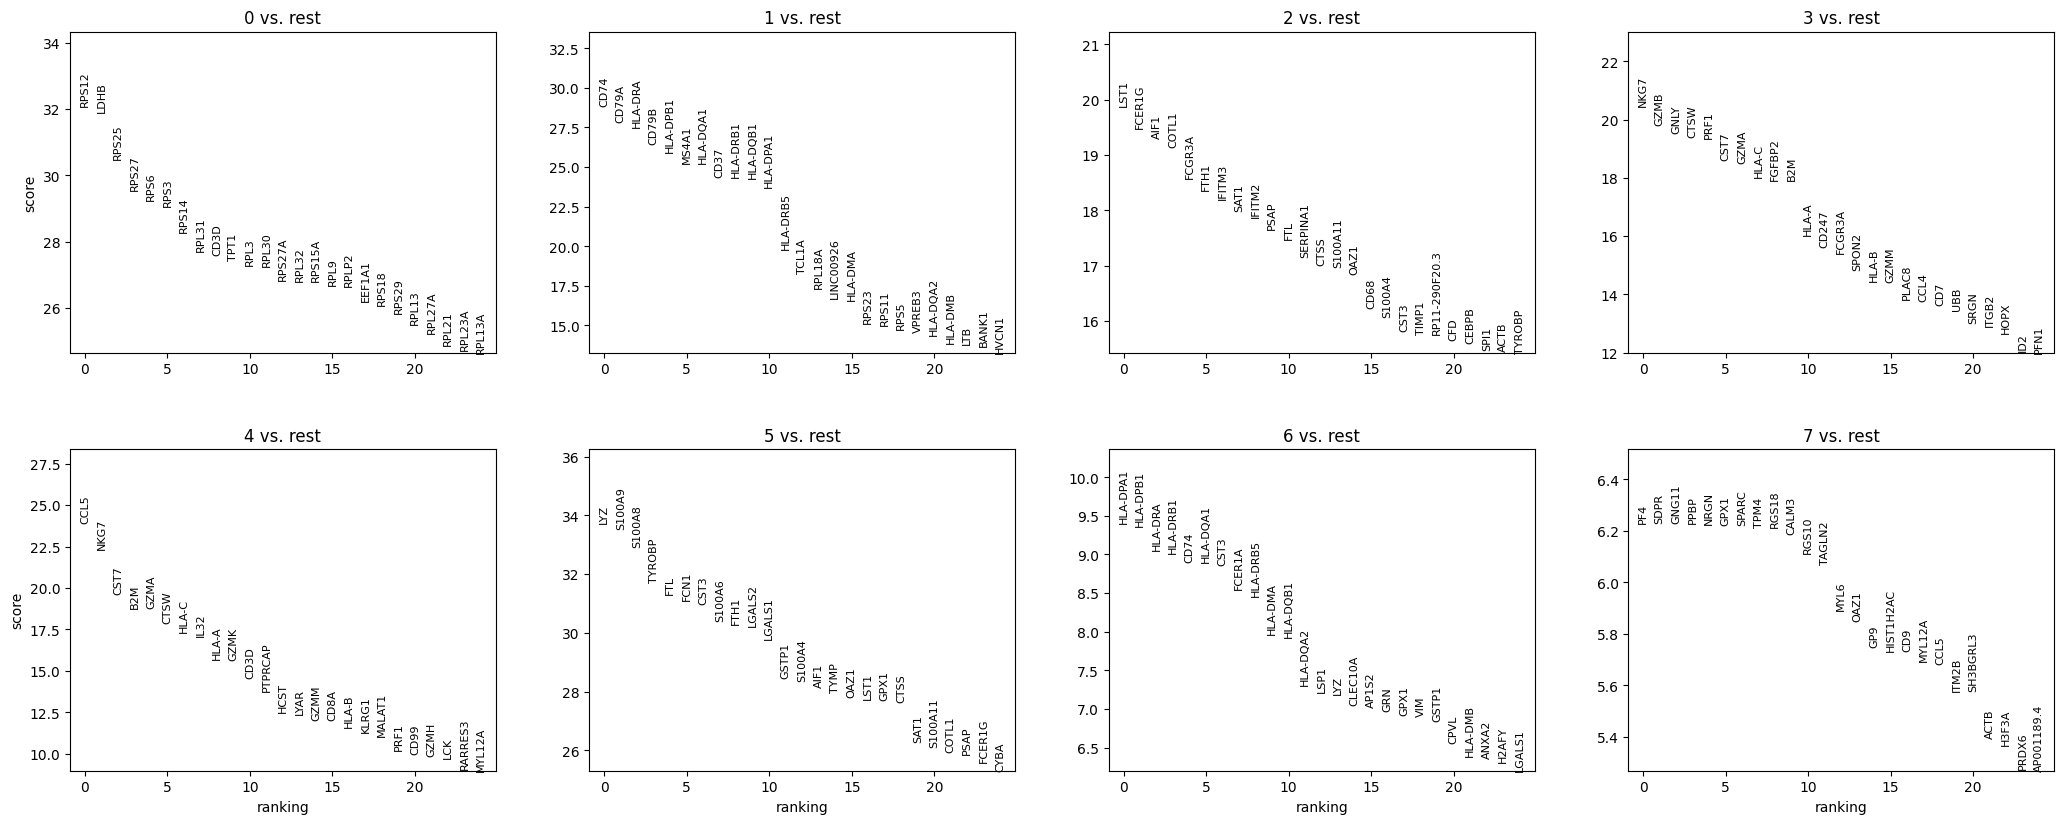

In [38]:
sc.tl.rank_genes_groups(adata, "leiden", method="wilcoxon")
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

In [39]:
adata.write(results_file)

**Define marker genes of interest**

In [40]:
marker_genes = [
    *["IL7R", "CD79A", "MS4A1", "CD8A", "CD8B", "LYZ", "CD14"],
    *["LGALS3", "S100A8", "GNLY", "NKG7", "KLRB1"],
    *["FCGR3A", "MS4A7", "FCER1A", "CST3", "PPBP"],
]

In [41]:
adata = sc.read(results_file)

In [42]:
adata 

AnnData object with n_obs × n_vars = 2638 × 1838
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden'
    var: 'gene_ids', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'hvg', 'leiden', 'leiden_colors', 'leiden_sizes', 'log1p', 'neighbors', 'paga', 'pca', 'rank_genes_groups', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [43]:
pd.DataFrame(adata.uns["rank_genes_groups"]["names"]).head(5)

,0,1,2,3,4,5,6,7
0,RPS12,CD74,LST1,NKG7,CCL5,LYZ,HLA-DPA1,PF4
1,LDHB,CD79A,FCER1G,GZMB,NKG7,S100A9,HLA-DPB1,SDPR
2,RPS25,HLA-DRA,AIF1,GNLY,CST7,S100A8,HLA-DRA,GNG11
3,RPS27,CD79B,COTL1,CTSW,B2M,TYROBP,HLA-DRB1,PPBP
4,RPS6,HLA-DPB1,FCGR3A,PRF1,GZMA,FTL,CD74,NRGN


In [44]:
result = adata.uns["rank_genes_groups"]
groups = result["names"].dtype.names
pd.DataFrame(
    {
        group + "_" + key[:1]: result[key][group]
        for group in groups
        for key in ["names", "pvals"]
    }
).head(5)

,0_n,0_p,1_n,1_p,2_n,2_p,3_n,3_p,4_n,4_p,5_n,5_p,6_n,6_p,7_n,7_p
0,RPS12,4.167598e-226,CD74,2.487145e-183,LST1,4.985426e-88,NKG7,3.591782e-93,CCL5,4.062586e-126,LYZ,2.844372e-249,HLA-DPA1,5.422417e-21,PF4,4.722886e-10
1,LDHB,1.794807e-223,CD79A,1.679730e-170,FCER1G,1.449472e-84,GZMB,2.033412e-87,NKG7,1.528118e-110,S100A9,2.651928e-246,HLA-DPB1,7.591860e-21,SDPR,4.733899e-10
2,RPS25,4.655800e-204,HLA-DRA,6.935111e-167,AIF1,5.833547e-83,GNLY,8.130223e-85,CST7,1.332168e-85,S100A8,8.731315e-238,HLA-DRA,1.306768e-19,GNG11,4.733899e-10
3,RPS27,9.438482e-192,CD79B,2.569135e-154,COTL1,1.261406e-81,CTSW,6.944632e-84,B2M,8.615108e-79,TYROBP,9.809633e-221,HLA-DRB1,1.865104e-19,PPBP,4.744938e-10
4,RPS6,5.767118e-188,HLA-DPB1,3.577195e-148,FCGR3A,4.610698e-77,PRF1,1.621421e-83,GZMA,1.480430e-78,FTL,3.676035e-215,CD74,5.853161e-19,NRGN,4.800511e-10


ranking genes
    finished (0:00:01)


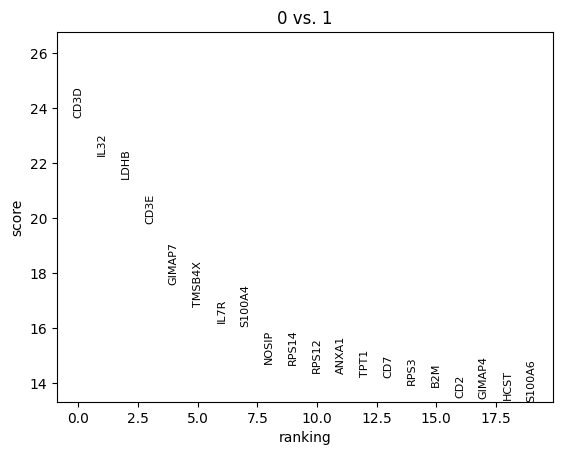

In [45]:
sc.tl.rank_genes_groups(adata, "leiden", groups=["0"], reference="1", method="wilcoxon")
sc.pl.rank_genes_groups(adata, groups=["0"], n_genes=20)

/Users/sasi/opt/anaconda3/lib/python3.9/site-packages/scanpy/plotting/_tools/__init__.py:1303: UserWarning: FixedFormatter should only be used together with FixedLocator
  _ax.set_xticklabels(new_gene_names, rotation="vertical")


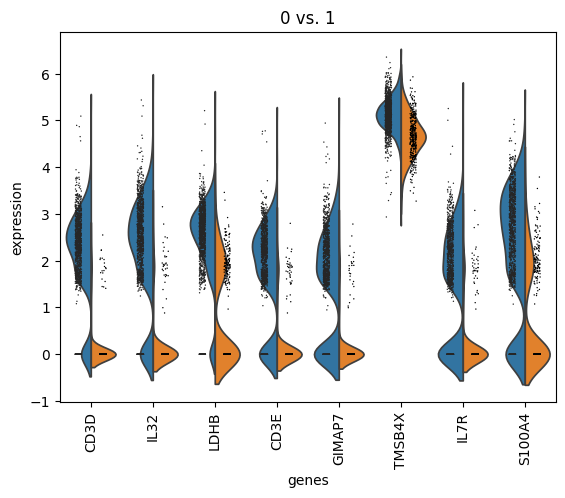

In [46]:
sc.pl.rank_genes_groups_violin(adata, groups="0", n_genes=8)

In [47]:
adata = sc.read(results_file)

/Users/sasi/opt/anaconda3/lib/python3.9/site-packages/scanpy/plotting/_tools/__init__.py:1303: UserWarning: FixedFormatter should only be used together with FixedLocator
  _ax.set_xticklabels(new_gene_names, rotation="vertical")


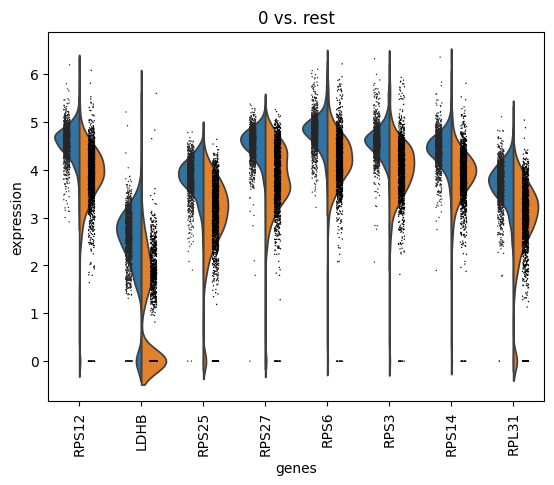

In [48]:
sc.pl.rank_genes_groups_violin(adata, groups="0", n_genes=8)

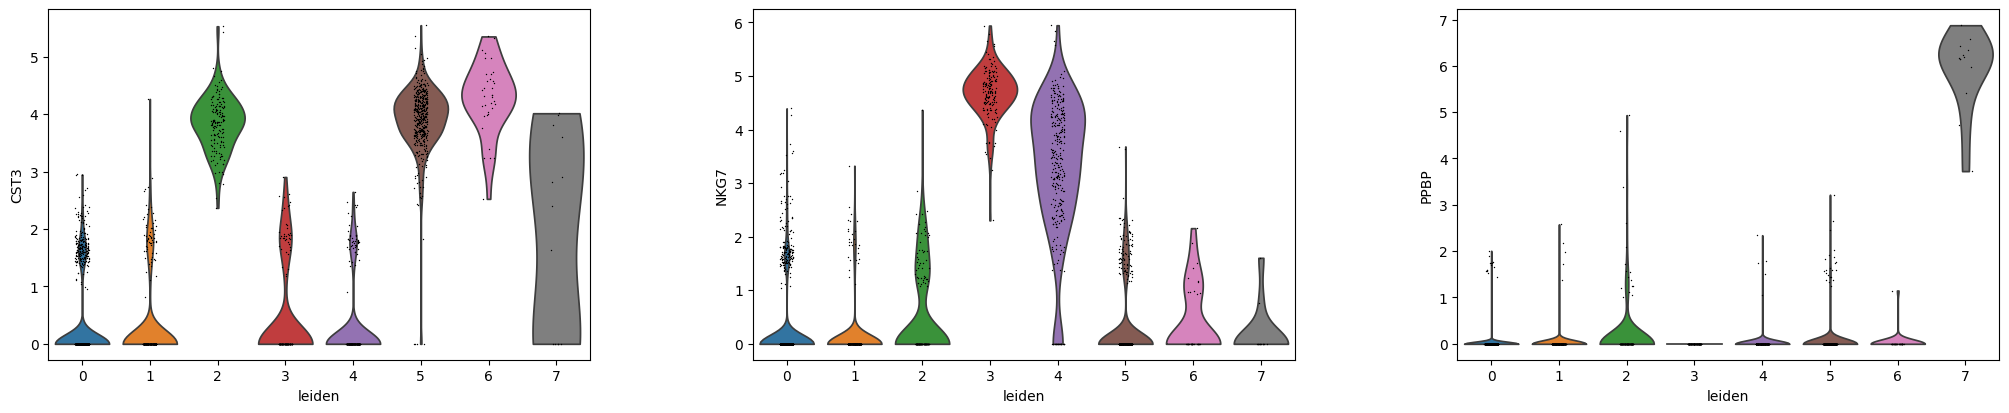

In [49]:
sc.pl.violin(adata, ["CST3", "NKG7", "PPBP"], groupby="leiden")

In [50]:
adata

AnnData object with n_obs × n_vars = 2638 × 1838
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden'
    var: 'gene_ids', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'hvg', 'leiden', 'leiden_colors', 'leiden_sizes', 'log1p', 'neighbors', 'paga', 'pca', 'rank_genes_groups', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

**Mark the cell types**

In [51]:
new_cluster_names = [
    "CD4 T",
    "B",
    "FCGR3A+ Monocytes",
    "NK",
    "CD8 T",
    "CD14+ Monocytes",
    "Dendritic",
    "Megakaryocytes",
]
adata.rename_categories("leiden", new_cluster_names)



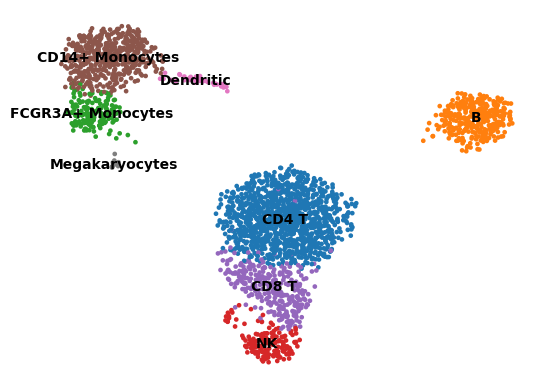

In [52]:
sc.pl.umap(
    adata, color="leiden", legend_loc="on data", title="", frameon=False, save=".pdf"
)

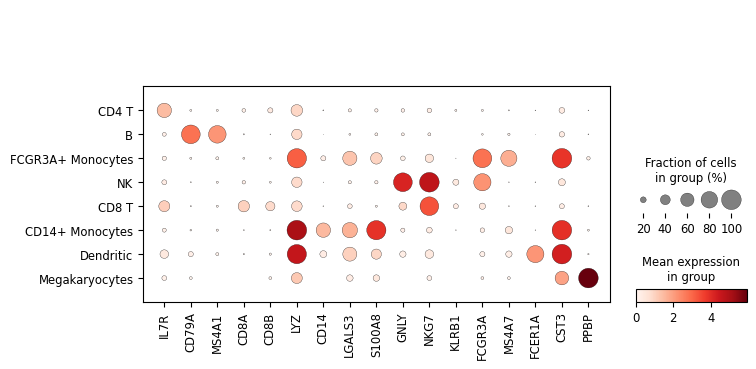

In [53]:
sc.pl.dotplot(adata, marker_genes, groupby="leiden");

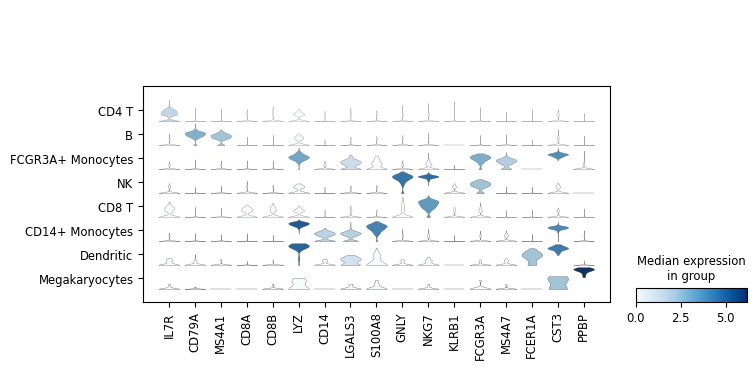

In [54]:
sc.pl.stacked_violin(adata, marker_genes, groupby="leiden");

In [55]:
adata

AnnData object with n_obs × n_vars = 2638 × 1838
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden'
    var: 'gene_ids', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'hvg', 'leiden', 'leiden_colors', 'leiden_sizes', 'log1p', 'neighbors', 'paga', 'pca', 'rank_genes_groups', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [56]:
# `compression='gzip'` saves disk space, and slightly slows down writing and subsequent reading
#adata.write(results_file, compression="gzip")

In [57]:
#adata.raw.to_adata().write("./write/pbmc3k_withoutX.h5ad")